</br>
<div style="display: flex; justify-content: space-between; align-items: flex-start; border-bottom: 2px solid #555555; padding-bottom: 15px; margin-bottom: -8px;">
    <div style="width: 50%;">
        <h2>
            <span style="color: #B30033;">▍</span>Práctica 1:
        </h2>
        <h1 style="margin-top: -10px;">
            Análisis, procesamiento y predicción supervisada
        </h1>
    </div>
    <div style="width: 50%; text-align: right;">
        <div style="display: flex; justify-content: space-between; align-items: flex-start; margin-top: 30px;">
            <div style="width: 20%;"></div>
            <div style="width: 80%; border-left: 2px solid #555555; padding-left: 20px;">
                <div style="margin-bottom: 20px;">
                    <p style="margin: 0; font-size: 1.4em; font-weight: bold;">
                        Aprendizaje Automático, 2025-26
                    </p>
                </div>
                <div style="margin-top: 8px; text-align: right;">
                    <span style="font-size: 1em; color: #D0D0D0;">
                        José Miguel Puerta Callejón
                    </span>
                    <a href="mailto:Jose.Puerta@uclm.es" style="text-decoration: none; color: #888888; font-size: 0.8em; padding-left: 15px;">
                        ✉ Jose.Puerta@uclm.es
                    </a>
                </div>
                <div style="margin-top: 8px; text-align: right;">
                    <span style="font-size: 1em; color: #D0D0D0;">
                        Pablo Torrijos Arenas
                    </span>
                    <a href="mailto:Pablo.Torrijos@uclm.es" style="text-decoration: none; color: #888888; font-size: 0.8em; padding-left: 15px;">
                        ✉ Pablo.Torrijos@uclm.es
                    </a>
                </div>
                </div>
            </div>
        </div>
    </div>
</div>

<div style="border-bottom: 2px solid #555555; padding-bottom: 25px; margin-bottom: 10px">
    <div style="display: flex; align-items: center; margin-bottom: 10px;">
        <span style="color: #B30033; font-size: 1.5em; margin-right: 10px;">▍</span>
        <h3 style="margin: 0; font-size: 1.4em; font-weight: bold">
            Estudiantes
        </h3>
    </div>
    <ul style="list-style-type: none; padding-left: 28px; margin: 0;  font-size: 1.1em">
        <li>Víctor Ortega Gómez</li>
        <li>Cristian Rubio Barato</li>
    </ul>

</div>

## 1. Introducción

El objetivo de esta práctica es aplicar un flujo de trabajo completo de **aprendizaje automático** para resolver un problema de **clasificación supervisada**. Se analizará un conjunto de datos simulado sobre visitas de pacientes a un hospital para predecir el **riesgo cardiovascular**.

El desarrollo abarcará todas las etapas del proceso:
* **Análisis Exploratorio de Datos (EDA)** y su **preprocesamiento**.
* **Selección y entrenamiento** de diversos modelos de clasificación.
* **Validación** robusta de los modelos (ej. validación cruzada) y ajuste de hiperparámetros.
* **Generación de predicciones** para la evaluación final.

El rendimiento de los modelos se evaluará en una competición privada en Kaggle.

<div style="border-bottom: 2px solid #555555; padding-bottom: 15px; margin-bottom: 10px"></div>

## 2. Carga y visualización de los datos

Se proporciona un conjunto de datos que registra visitas de pacientes. Los datos contienen una variedad de tipos de variables, valores faltantes y otros artefactos que deberán ser gestionados.

Comenzamos importando las librerías necesarias y cargando los conjuntos de datos de entrenamiento (`cardio_risk_train.csv`) y de prueba (`cardio_risk_test.csv`) para poder examinarlos:

In [ ]:
!pip install dython --quiet # Será necesario para tener la librería en Google Collab y posteriormente importarla

In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

df_train = pd.read_csv('cardio_risk_train.csv')
df_test = pd.read_csv('cardio_risk_test.csv')

# 3. Importación de librerías y configuraciones

Se importarán las librerías necesarias tanto para la ejecución de la práctica y modelos como para el análisis exploratorio de los datos.

In [ ]:
# Standard
import warnings

# Third party
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import numpy as np
import seaborn as sns
from dython.nominal import associations
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, PowerTransformer, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

Configuración para la visualización de las gráficas

In [ ]:
%matplotlib inline
figsize = (12, 7)  # Width, height in inches
palette = "colorblind"  # Palette definition
plt.rcParams["figure.figsize"] = figsize
sns.set_palette(palette)

Fijamos una semilla para la reproducibilidad de los experimentos

In [ ]:
random_state = seed = 41686

Configuración de pandas para siempre devolver un dataset pandas y no numpy de forma que se facilite el procesamiento de los datos

In [ ]:
transform_output = "pandas"  # Pandas output
set_config(transform_output=transform_output)

Desactivación de mensajes de advertencia para evitar resultados de las celdas demasiado largos

In [ ]:
action = "ignore"  # Never print matching warnings
warnings.filterwarnings(action)

El dataset ya está dividido en una parte para training y otra para testing por lo que nos saltaremos dicho paso. Esta división es importante para realizar un análisis exploratorio de datos únicamente con el dataset de training para evitar el *data leakage* o fuga de datos.

Lo que sí haremos es definir la variable que queremos predecir

In [ ]:
target = "riesgo_cv"
axis = "columns"

# Separar X e y en el conjunto de entrenamiento
X_train = df_train.drop(target, axis=1) # Nos quedamos con las variables que predicen riesgo_cv
y_train = df_train[target] # Separamos la columna de riesgo_cv

n = 5
X_train.sample(n, random_state=random_state)

## 4. Análisis exploratorio de los datos

En esta parte del cuaderno se realizará un análisis exploratorio de los datos y se comentarán las diferentes observaciones y las decisiones que se tomarán en función de dichas observaciones

### 4.1 Análisis de la variable objetivo

Primero realizaremos un análisis de la variable que se quiere predecir para ver cómo de balanceadas están las clases y detectar si será necesario un ajuste de los pesos del modelo.


In [ ]:
# Plot the distribution of the target variable
stat = "proportion"  # Normalize to proportions
title = "Distribución de la variable objetivo en el conjunto de entrenamiento"  # Text to use for the title
xlabel = "Riesgo_cv"  # Text to use for the x-axis label
ylabel = "Proporción"  # Text to use for the y-axis label
sns.countplot(x=y_train, stat=stat)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

Cómo se puede observar, el conjunto de datos se encuentra desbalanceado lo cuál tendrá un impacto en la evaluación del modelo ya que un modelo que siempre prediga *riesgo_cv* a 0 presentará una mayor tasa de acierto sin ser un buen clasificador.

### 4.2 Análisis de las variables predictoras

#### 4.2.1 Análisis de las variables numéricas

Para el análisis de las variables numéricas comenzaremos con el uso de `.describe()` con lo que obtendremos métricas claves. Se busca:

* **Escalas:** Diferencias drásticas en los rangos.
* **Valores extremos:** Diferencias grandes entre el 75% (`Q3`) y el máximo (`max`).
* **Asimetría:** Si la media es muy diferente de la mediana (`Q2`).

In [ ]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
X_train[numerical_features].describe().T

Se puede observar que hay problemas de escalas ya que las variables presentan rangos de valores bastante diferentes entre sí por lo que se deberá de realizar una normalización de los datos.

También se puede observar que el *count* no es 24000 para todas las variables por lo que existen algunas que presentan valores nulos o perdidos por lo que se deberá de realizar un tratamiento de esas variables. Un ejemplo de esto es glucosa_ayunas. Para este tipo de variables se aplicará la moda en los valores que sean *null*

Se puede observar que ciertas variables presentan también valores extremos debido a que el valor máximo encontrado dista mucho del *Q3* como por ejemplo *presión_sistolica_2*. Para mitigar esto se hará uso de la transformación de potencia.

Respecto al desbalance de las muestras no se han observado grandes diferencias en *Q2* con respecto a la media por lo que no hay desbalance para ninguna de estas variables

In [ ]:
# Create plots
for column in numerical_features:
    # Set up the figure
    plt.figure()

    # Plot 1: Histogram
    plt.subplot(1, 2, 1)
    x = X_train[column]
    kde = True  # Compute a kernel density estimate to smooth the distribution
    title = f"Histograma"
    sns.histplot(x=x, kde=kde)
    plt.title(title)

    # Plot 2: Boxplot
    plt.subplot(1, 2, 2)
    x = X_train[column]
    title = f"Diagrama de caja"
    sns.boxplot(x=x)
    plt.title(title)

    suptitle = f'Análisis de la variable "{column}"'  # Text to use for the title of the entire figure
    plt.suptitle(suptitle)

Cómo se puede observar en las gráficas, es necesario un escalado debido a que las variables cuentan con escalas muy diferentes. También se puede ver la existencia de valores extremos claros para ciertas variables.

Todas las variables se encuentran también distribuidas excepto con dos casos especiales. Estas variables son *fumador* y *antecedentes_familiares*. Estas dos variables toman unicamente los valores 0 y 1 lo que nos indica que estas variables que son númericas en realidad representan variables categóricas donde 0 significa que no es fumador o no tiene antecedentes familiares y donde 1 significa lo opuesto.

#### 4.2.2 Análisis de las variables categóricas

Ahora, analizaremos las variables categóricas de las que no nos interesa la media o la mediana como con las númericas, sino que nos interesan:

* **Cardinalidad:** Cuántos valores únicos (`unique`) tiene cada una. Una cardinalidad alta (muchas categorías) puede ser problemática.
* **Frecuencia:** Cuál es el valor más frecuente (`top`) y cuántas veces aparece (`freq`).
* **Valores faltantes ocultos:** Si el valor más frecuente (`top`) o la lista de valores únicos revela la presencia de `"unknown"` u otros marcadores.

In [ ]:
categorical_features = X_train.select_dtypes(include="object").columns.tolist()
X_train[categorical_features].describe().T

Podemos observar que todas las variables presentan una gran cantidad de valores unicos (*unique*), pero *fecha_visita*, *notas_medicas* y *actividad_fisica* son especiales ya que son variables que tienen valores únicos no por categorías sino porque una son fechas y las otras son notas escritas a mano. Estas variables deberán de ser eliminadas debido a que no se pueden procesar correctamente para aportar información al modelo.

Por otro lado *hospital_origen*, aunque tiene una alta cardinalidad, entra dentro de lo entendible debido a que son identificadores de hospitales por lo que esta variable sí podría ser tratada con un one-hot encoding.

Respecto a valores pérdidos ninguna los presenta a excepción de *notas_medicas* pero como esa variable va a ser eliminada no es relevante.

In [ ]:
for column in categorical_features:
    # Set up the figure
    plt.figure()

    # Plot: Count plot
    y = X_train[column]
    order = X_train[column].value_counts().index  # Sort the bars by frequency for better readability
    stat = "proportion"  # Normalize to proportions
    sns.countplot(y=y, order=order, stat=stat)
    title = f'Diagrama de barras para "{column}"'
    xlabel = column
    ylabel = "Proporción"
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Como se puede observar en los gráficos, las variables presentan una cardinalidad exagerada a excepción de *hospital_origen*. Esta variable se puede observar bien y comprobar que ninguna categoría predomina sobre otra por lo que se encuentra balanceada.

### 4.2.3 Análisis en profundidad de los valores perdidos o nulos

A pesar de que ya hemos podido ver que práctiamente no existen valores perdidos o nulos, vamos a realizar un análisis en mayor profundidad para conocer exactamente cúantos hay y las variables en las que se concentran.

In [ ]:
df = X_train.copy()
mapping = {"unknown": pd.NA}
df = df.replace(mapping)
msno.matrix(df)

Cómo se puede ver existen unicamente 3 variables que presentan valores perdidos. Una de ellas es *notas_medicas* que ya se decidió que sería eliminada por lo que no nos interesa.

*fumador* no presenta un alto número de valores nulos o perdidos. Debido a que representa si alguien es fumador o no, en vez de completar esos valores nulos con la moda como se decidió en un principio, se hará poniendo el número 2 indicando que se desconoce la información.

*glucosa_ayunas* presenta una gran cantidad de valores perdidos por lo que la mejor opción será eliminarla para no introducir ruido en los datos



### 4.2.4 Detección de duplicados e inconsistencias

Procederemos a la detección de entradas de datos duplicadas y la verificación de inconsistencias básicas, como formatos incorrectos o valores fuera de los rangos esperados, con el fin de garantizar la calidad y coherencia del conjunto de datos. Dado que ya se realizó una revisión de los rangos durante la exploración inicial de las variables, no es necesario volver repetir este análisis.

In [ ]:
duplicates = df_train.duplicated()
num_duplicates = duplicates.sum()
print(f"Número de filas duplicadas: {num_duplicates}")

No se han encontrado entradas de datos duplicadas.

También es posible identificar duplicados parciales, es decir, registros que comparten el mismo identificador pero presentan diferencias en otros campos.

In [ ]:
# Detect duplicate indices
keep = False  # Mark all duplicates as "True"
mask = df.index.duplicated(keep=keep)
duplicated_indices = df.index[mask]

# Filter records with duplicate indices
duplicated_records = df.loc[duplicated_indices]

# Verify if, for each duplicated index, the records are different
# Group by index and check if there are multiple unique rows
level = 0  # Group by index level
function = lambda group: group.drop_duplicates().shape[0] > 1
grouped = duplicated_records.groupby(level=level).filter(function)

# Display the found records
print("Duplicados parciales (mismo índice, datos diferentes):")
grouped

No existe ningún tipo de entrada duplicada ni con duplicados parciales

### 4.2.5 Análisis de correlaciones

El análisis de correlaciones permite evaluar la intensidad y el sentido de la relación entre distintas variables, lo que ayuda a identificar patrones, seleccionar características relevantes y detectar redundancias o posibles problemas de multicolinealidad que puedan afectar la interpretación y el desempeño de los modelos predictivos; para facilitar esta interpretación, a continuación se mostrará un mapa de calor de la matriz de correlaciones, que ofrece una representación adecuada de relaciones entre variables de diferentes tipos.

In [ ]:
df = X_train.copy()
loc = df.shape[1]  # Insertion index
df.insert(loc, target, y_train)
_ = associations(df)

* **Relaciones entre la variable clase (*riesgo_cv*) y variables predictoras:**
    * **riesgo_cv y notas_medicas:** Muestran una asociación fuerte pero debido a que se iba a eliminar por los motivos que ya se han explicado, esto no es relevante.
    * **riesgo_cv y glucosa_ayunas:** Muestran una asociación moderada pero debido a que se iba a eliminar por los motivos que ya se han explicado, esto no es relevante.
    * **riesgo_cv y ldl:** Muestran una asociación moderada, lo que indica que es una variable importante para la predicción del riesgo_cv.

    * **riesgo_cv y presion_sistolica_X:** Muestran una asociación moderada con todas las variables de presión sistólic, lo que indica que son variables importantes para la predicción del riesgo_cv.

    * **riesgo_cv y edad:** Muestran una asociación moderada lo que indica que la edad de una persona influye mucho en la predicción del riesgo_cv.

    * **riesgo_cv y fecha_visita:** Muestran una asociación de 1. Esto se debe a que fecha_visita siempre cambia. No es una variable relevante y se procederá a eliminar ya que no aporta información.

    * **riesgo_cv y id:** Muestran una asociación muy alta. Esto se debe a lo mismo que con *fecha_visita*. *id* no es una variable importante y no aporta información, simplemente es un identificador.

* **Relaciones entre variables predictoras:**
    * **imc, peso_kg y altura_cm:** Están moderadamente asociadas entre ellas, lo cual es normal debido a que el imc se cálcula con el peso y la altura de una persona.

    * **edad y presion_sistolica_X:** Están moderadamente asociadas entre ellas, lo cual es un indicativo de que la presión aumenta con la edad.

    * **edad y glucosa_ayunas:** Están moderadamente asociadas entre ellas pero glucosa_ayunas es una variable que se va a eliminar por lo que no es relevante.


# 5. Ingeniería de características

Ahora vamos a proponer algunas transformaciones y la creación de nuevas variables.

El objetivo es **justificar** por qué estas transformaciones deberían incorporarse en nuestro `Pipeline` final. Para ello, generaremos las nuevas características y las enviaremos a una función de visualización junto con `y_train`, con el fin de evaluar su capacidad discriminativa.

En otras palabras, queremos comprobar si la nueva variable que creemos ayuda a separar adecuadamente las clases. Para evaluarlo utilizaremos:

- **Gráficos de densidad** para comparar las distribuciones entre ambas clases. Cuanto más separadas estén las distribuciones, mayor será el poder discriminativo de la característica.


## 5.1 Tratamiento de las variables presion_sistolica_X

Existen 3 variables para la presión sistólica que pueden ser diferentes medidas por lo que crearemos una variable que sea la desviación estándar ya que una presión variable puede ser un factor de riesgo cardiovascular.

In [ ]:
def plot_density(x, y=None):
    """Plot the density of a numerical feature. Optionally, separate by classes in y."""
    x = x.squeeze()

    plt.figure(figsize=(8,5))

    if y is not None:
        # Graficar densidad por cada clase de y
        for cls in y.unique():
            sns.kdeplot(x[y == cls], label=f"{y.name}={cls}", fill=True, alpha=0.3)
        plt.legend()
    else:
        # Graficar densidad sin diferenciar clases
        sns.kdeplot(x, fill=True, alpha=0.3)

    plt.xlabel(x.name)
    plt.ylabel("Density")
    plt.title("Density Plot")
    plt.show()

fe_features_pdays = ["pdays"]
fe_feature_age = ["age"]
fe_features_job = ["job"]
fe_features_campaign = ["campaign"]
fe_features_month = ["month"]

In [ ]:
presion_sistolica_des_name = "presion_sistolica_des"
presion_sistolica_des_function = lambda X: X[["presion_sistolica_1", "presion_sistolica_2", "presion_sistolica_3"]].std(axis=1).to_frame(name=presion_sistolica_des_name)
presion_sistolica_des = presion_sistolica_des_function(X_train)
plot_density(presion_sistolica_des, y_train)

No se encuentran muy separadas por lo que el poder discrimantivo no es mucho

# 6. Preprocesamiento

No se modifica `X_train` directamente. En su lugar, definimos un **Pipeline** que aplica automáticamente todas las transformaciones necesarias (imputación, codificación, escalado, etc.) al tipo de columna correspondiente.

Ventajas:

1. **Evita fuga de datos:** las estadísticas de preprocesamiento se calculan solo con los datos de entrenamiento y se aplican de forma consistente al test.  
2. **Reproducible y eficiente:** el mismo Pipeline se puede usar en cualquier conjunto de datos sin preprocesamiento manual.  
3. **Compatible con validación cruzada:** garantiza que cada fold se procesa solo con sus datos de entrenamiento, evitando errores y fugas.


### 6.1. Diseño de un `Pipeline` de preprocesamiento robusto


La mejor práctica es usar **un único `ColumnTransformer`** como procesador principal.  
Dentro de él, **cada grupo de atributos puede tener su propio `Pipeline`**, permitiendo aplicar secuencias distintas de transformaciones a diferentes tipos de columnas de manera ordenada y eficiente.

El diseño sigue estos pasos:


#### 6.1.1. Definir las listas de atributos



Primero, agrupamos los atributos según el tipo de procesamiento que recibirán:

- `numerical_features`: columnas numéricas (`balance`, `day`, `previous`) → imputación por mediana → transformación de potencia → escalado estándar.
- `categorical_features_mode_ohe`: columna categórica `marital` → imputación por moda → `OneHotEncoder`.
- `categorical_features_constant_ohe`: columna categórica `contact` → imputación con constante (`"unknown"`) → `OneHotEncoder`.
- `ordinal_features_binary`: columnas binarias (`default`, `housing`, `loan`) → imputación por moda → `OrdinalEncoder`.
- `ordinal_feature_education`: columna ordinal `education` → `OrdinalEncoder` con orden específico.
- Columnas de **ingeniería de características** (`pdays`, `age`, `job`, `campaign`, `month`) → enviadas a pipelines de transformación personalizada.
- Columnas a **eliminar** (`poutcome`, `duration`) → no se incluyen en ninguna lista y se usan `remainder="drop"` en el `ColumnTransformer`.

In [ ]:
numerical_values = ["edad", "altura_cm", "peso_kg", "imc","presion_sistolica_1", "presion_sistolica_2", "presion_sistolica_3", "colesterol_total","hdl","ldl","talla_zapato"]
one_hot_encoding = ["hospital_origen"]
binary =  ["fumador", "antecedentes_familiares"]
fe_presion_sistolica_des = ["presion_sistolica_1", "presion_sistolica_2", "presion_sistolica_3"]


Ahora definimos los pipeline

In [ ]:
scaler = StandardScaler()
transformer = PowerTransformer()
numerical_values_transformer = make_pipeline(scaler,transformer)

In [ ]:
handle_unknown = "ignore"
sparse_output = False
ohe = OneHotEncoder(handle_unknown=handle_unknown, sparse_output=sparse_output)
one_hot_encoding_transformer = make_pipeline(ohe)

In [ ]:
imputer = SimpleImputer(strategy='constant', fill_value=2)
ordinal_transformer_binary = make_pipeline(imputer)

In [ ]:
strategy = "median"
imputer = SimpleImputer(strategy=strategy)
validate = False
transformer = FunctionTransformer(presion_sistolica_des_function, validate=validate)
fe_presion_sistolica_des_transformer = make_pipeline(imputer, transformer)

Creamos el ColumnTransformer

In [ ]:
remainder = "drop"  # Drop any columns not specified in the transformer: ["notas_medicas", "fecha_visita", "id", "actividad_fisica","glucosa_ayunas"]
verbose_feature_names_out = False  # Get clean feature names

preprocessor_final = make_column_transformer(
    (numerical_values_transformer, numerical_values),
    (one_hot_encoding_transformer, one_hot_encoding),
    (ordinal_transformer_binary, binary),
    (fe_presion_sistolica_des_transformer, fe_presion_sistolica_des),
    remainder=remainder,
    verbose_feature_names_out=verbose_feature_names_out
)

#### 6.1.2. Visualización del resultado

In [ ]:
preprocessor_final.fit_transform(X_train).sample(n, random_state=random_state)

## Flujo de Trabajo y Requisitos

El desarrollo de la práctica deberá seguir las siguientes etapas:

### 3.1. Análisis Exploratorio de Datos (EDA)

Se debe realizar un análisis inicial para comprender la naturaleza de los datos. Este análisis debe incluir:
* Distribución de la variable objetivo (`riesgo_cv`).
* Análisis de valores faltantes (aleatorios y estructurales).
* Distribución de las variables numéricas y categóricas, valores únicos, etc.
* Identificación y tratamiento (si se considera) de valores atípicos (*outliers*).
* Relaciones entre las variables y la variable objetivo.

Las conclusiones de este análisis deben servir para justificar las decisiones tomadas en la siguiente etapa.

### 3.2. Preprocesamiento de Datos

Esta etapa es fundamental para preparar los datos antes de la modelización. Las tareas incluyen la imputación de valores faltantes, la codificación de variables categóricas, la ingeniería de características (ej. creación de nuevas variables a partir de las existentes), el escalado de datos o incluso eliminar variables que no aporten información.

Este proceso debe de ir totalmente ligado al EDA. Las conclusiones que hayamos sacado en el estudio son las que nos deben guiar en este paso. Del mismo modo, al preprocesar los datos y entrenar los modelos podemos sacar nuevas conclusiones que nos permitan entender mejor los datos (como habéis visto en **CRISP-DM**):

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/CRISP-DM_Process_Diagram.png" alt="Diagrama de Proceso CRISP-DM" width="550"/>

Todo el proceso de transformación de datos **debe** encapsularse en `Pipelines` y/o `ColumnTransformers` de `scikit-learn`. Esto garantiza la reproducibilidad y evita fugas de datos (*data leakage*).

### 3.3. Modelización y Validación

Se deben entrenar y evaluar correctamente **varios algoritmos** de clasificación (ej. Árboles de Decisión, Naive Bayes, k-NN, Random Forest, etc.) para comparar su rendimiento y seleccionar el más eficaz.

Se deberá realizar un **ajuste de hiperparámetros** para optimizar los modelos, pudiendo emplear técnicas como `GridSearchCV` o `RandomizedSearchCV` en `scikit-learn`.

La evaluación y comparación de los modelos **debe** realizarse mediante una estrategia de **validación cruzada**. Además, es importante tener en cuenta distintas **métricas** para evaluar nuestro modelo, prestando especial atención a la métrica de la competición (F1-Score).

### 3.4. Predicción y Evaluación

El modelo final seleccionado (entrenado sobre *todo* el conjunto de `train`) se utilizará para generar predicciones sobre el conjunto `cardio_risk_test.csv`.

El fichero de predicciones deberá seguir el formato especificado en `sample_submission.csv`:

In [ ]:
df_kaggle = pd.read_csv('sample_submission.csv')
df_kaggle

# 3.3. MODELIZACIÓN Y VALIDACIÓN

---

## 📋 Objetivo de esta Sección

En esta fase del proyecto procedemos a:

1. **Entrenar múltiples algoritmos de clasificación** (Random Forest, XGBoost, LightGBM, CatBoost, etc.)
2. **Optimizar hiperparámetros** mediante técnicas como GridSearchCV o RandomizedSearchCV
3. **Validar modelos con validación cruzada** para obtener métricas robustas y evitar overfitting
4. **Comparar rendimiento** utilizando múltiples métricas, con énfasis en **F1-Score** (métrica de la competición)
5. **Seleccionar el mejor modelo** basándonos en los resultados de validación cruzada

---

## 🎯 Estrategia de Evaluación

- **Validación Cruzada**: Utilizaremos k-fold cross-validation (típicamente k=5 o k=10)
- **Métricas a considerar**:
  - **F1-Score** (métrica principal de la competición)
  - Accuracy
  - Precision
  - Recall
  - ROC-AUC
  
- **Ajuste de hiperparámetros**: Se aplicará GridSearchCV o RandomizedSearchCV para optimizar cada modelo

---

## 📊 Modelos a Evaluar

Los siguientes algoritmos serán entrenados y comparados:

1. **Random Forest Classifier** - Baseline robusto
2. **Gradient Boosting Classifier** - Boosting tradicional
3. **XGBoost** - Gradient boosting optimizado
4. **LightGBM** - Boosting ultrarrápido
5. **CatBoost** - Especializado en variables categóricas
6. **Voting Classifier** - Ensemble de los mejores modelos

---

## 🔄 Flujo de Trabajo


<div style="border-bottom: 2px solid #555555; margin-bottom: 10px"></div>

# RANDOM FOREST CLASSIFIER

**Descripción**: Ensemble de múltiples árboles de decisión que votan para la clasificación final.

**Ventajas**:
- Robusto frente al overfitting
- Maneja bien datos no lineales
- Proporciona importancia de variables
- No requiere normalización de datos

**Parámetros clave**:
- `n_estimators`: número de árboles en el bosque
- `max_depth`: profundidad máxima de cada árbol
- `min_samples_split`: mínimo de muestras para dividir un nodo

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import pandas as pd

# Entrenar Random Forest
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=random_state,
    n_jobs=-1
)

pipeline_rf = make_pipeline(preprocessor_final, model_rf)
pipeline_rf.fit(X_train, y_train)

# Evaluar en train
y_pred_rf = pipeline_rf.predict(X_train)
print("=== RANDOM FOREST - Training Performance ===")
print(classification_report(y_train, y_pred_rf))

# Cargar datos de test
test = pd.read_csv("cardio_risk_test.csv")

# Generar predicciones
y_test_pred_rf = pipeline_rf.predict(test)

# Crear submission
submission_rf = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_rf
})

# Guardar
submission_rf.to_csv("submission_random_forest.csv", index=False)
print("\n✅ Archivo 'submission_random_forest.csv' generado correctamente.")

=== RANDOM FOREST - Training Performance ===
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     18744
           1       0.90      0.67      0.77      5256

    accuracy                           0.91     24000
   macro avg       0.91      0.83      0.86     24000
weighted avg       0.91      0.91      0.91     24000


✅ Archivo 'submission_random_forest.csv' generado correctamente.


---
# GRADIENT BOOSTING CLASSIFIER

**Descripción**: Construye árboles de forma secuencial, donde cada árbol corrige los errores del anterior.

**Ventajas**:
- Alta precisión en problemas complejos
- Menos propenso al overfitting que Random Forest
- Captura relaciones no lineales complejas

**Desventajas**:
- Más lento en entrenamiento
- Requiere más ajuste de hiperparámetros

**Parámetros clave**:
- `n_estimators`: número de árboles secuenciales
- `learning_rate`: tasa de aprendizaje (más bajo = más robusto pero más lento)
- `max_depth`: profundidad de cada árbol

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import pandas as pd

# Entrenar Gradient Boosting
model_gb = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    random_state=random_state
)

pipeline_gb = make_pipeline(preprocessor_final, model_gb)
pipeline_gb.fit(X_train, y_train)

# Evaluar en train
y_pred_gb = pipeline_gb.predict(X_train)
print("=== GRADIENT BOOSTING - Training Performance ===")
print(classification_report(y_train, y_pred_gb))

# Cargar datos de test
test = pd.read_csv("cardio_risk_test.csv")

# Generar predicciones
y_test_pred_gb = pipeline_gb.predict(test)

# Crear submission
submission_gb = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_gb
})

# Guardar
submission_gb.to_csv("submission_gradient_boosting.csv", index=False)
print("\n✅ Archivo 'submission_gradient_boosting.csv' generado correctamente.")

=== GRADIENT BOOSTING - Training Performance ===
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     18744
           1       0.80      0.65      0.72      5256

    accuracy                           0.89     24000
   macro avg       0.85      0.80      0.83     24000
weighted avg       0.88      0.89      0.88     24000


✅ Archivo 'submission_gradient_boosting.csv' generado correctamente.


--- 
# XGBOOST (eXtreme Gradient Boosting)

**Descripción**: Implementación optimizada de gradient boosting, muy popular en competiciones de ML.

**Ventajas**:
- Extremadamente rápido y eficiente
- Regularización incorporada (L1 y L2)
- Maneja valores faltantes automáticamente
- Paralelización eficiente
- Ganador frecuente en Kaggle

**Cuándo usarlo**:
- Datasets estructurados/tabulares
- Cuando se necesita alto rendimiento
- Competiciones de Machine Learning

**Parámetros clave**:
- `n_estimators`: número de árboles
- `learning_rate`: velocidad de aprendizaje
- `max_depth`: profundidad máxima
- `eval_metric`: métrica de evaluación

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import pandas as pd

# Entrenar XGBoost
model_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=random_state,
    eval_metric='logloss',
    use_label_encoder=False
)

pipeline_xgb = make_pipeline(preprocessor_final, model_xgb)
pipeline_xgb.fit(X_train, y_train)

# Evaluar en train
y_pred_xgb = pipeline_xgb.predict(X_train)
print("=== XGBOOST - Training Performance ===")
print(classification_report(y_train, y_pred_xgb))

# Cargar datos de test
test = pd.read_csv("cardio_risk_test.csv")

# Generar predicciones
y_test_pred_xgb = pipeline_xgb.predict(test)

# Crear submission
submission_xgb = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_xgb
})

# Guardar
submission_xgb.to_csv("submission_xgboost.csv", index=False)
print("\n✅ Archivo 'submission_xgboost.csv' generado correctamente.")

=== XGBOOST - Training Performance ===
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     18744
           1       0.88      0.73      0.80      5256

    accuracy                           0.92     24000
   macro avg       0.90      0.85      0.87     24000
weighted avg       0.92      0.92      0.92     24000


✅ Archivo 'submission_xgboost.csv' generado correctamente.


---
# LIGHTGBM (Light Gradient Boosting Machine)

**Descripción**: Algoritmo de gradient boosting desarrollado por Microsoft, optimizado para velocidad y eficiencia.

**Ventajas**:
- MÁS RÁPIDO que XGBoost en datasets grandes
- Menor uso de memoria
- Soporta datos categóricos nativamente
- Excelente para datasets con muchas características
- Crecimiento de árbol leaf-wise (más preciso)

**Diferencias con XGBoost**:
- LightGBM crece leaf-wise (hoja a hoja)
- XGBoost crece level-wise (nivel a nivel)
- LightGBM es más rápido pero puede hacer overfitting más fácil

**Parámetros clave**:
- `n_estimators`: número de árboles
- `learning_rate`: tasa de aprendizaje
- `max_depth`: profundidad máxima (-1 = sin límite)

In [29]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import pandas as pd

# Entrenar LightGBM
model_lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    random_state=random_state,
    verbose=-1
)

pipeline_lgbm = make_pipeline(preprocessor_final, model_lgbm)
pipeline_lgbm.fit(X_train, y_train)

# Evaluar en train
y_pred_lgbm = pipeline_lgbm.predict(X_train)
print("=== LIGHTGBM - Training Performance ===")
print(classification_report(y_train, y_pred_lgbm))

# Cargar datos de test
test = pd.read_csv("cardio_risk_test.csv")

# Generar predicciones
y_test_pred_lgbm = pipeline_lgbm.predict(test)

# Crear submission
submission_lgbm = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_lgbm
})

# Guardar
submission_lgbm.to_csv("submission_lightgbm.csv", index=False)
print("\n✅ Archivo 'submission_lightgbm.csv' generado correctamente.")

=== LIGHTGBM - Training Performance ===
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     18744
           1       0.86      0.71      0.78      5256

    accuracy                           0.91     24000
   macro avg       0.89      0.84      0.86     24000
weighted avg       0.91      0.91      0.91     24000


✅ Archivo 'submission_lightgbm.csv' generado correctamente.


---
# XGBOOST (eXtreme Gradient Boosting)

**Descripción**: Implementación optimizada de gradient boosting, muy popular en competiciones de ML.

**Ventajas**:
- Extremadamente rápido y eficiente
- Regularización incorporada (L1 y L2)
- Maneja valores faltantes automáticamente
- Paralelización eficiente
- Ganador frecuente en Kaggle

**Cuándo usarlo**:
- Datasets estructurados/tabulares
- Cuando se necesita alto rendimiento
- Competiciones de Machine Learning

**Parámetros clave**:
- `n_estimators`: número de árboles
- `learning_rate`: velocidad de aprendizaje
- `max_depth`: profundidad máxima
- `eval_metric`: métrica de evaluación

In [30]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import pandas as pd

# Entrenar CatBoost
model_catboost = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    random_state=random_state,
    verbose=0
)

pipeline_catboost = make_pipeline(preprocessor_final, model_catboost)
pipeline_catboost.fit(X_train, y_train)

# Evaluar en train
y_pred_catboost = pipeline_catboost.predict(X_train)
print("=== CATBOOST - Training Performance ===")
print(classification_report(y_train, y_pred_catboost))

# Cargar datos de test
test = pd.read_csv("cardio_risk_test.csv")

# Generar predicciones
y_test_pred_catboost = pipeline_catboost.predict(test)

# Crear submission
submission_catboost = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_catboost
})

# Guardar
submission_catboost.to_csv("submission_catboost.csv", index=False)
print("\n✅ Archivo 'submission_catboost.csv' generado correctamente.")

=== CATBOOST - Training Performance ===
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     18744
           1       0.78      0.61      0.68      5256

    accuracy                           0.88     24000
   macro avg       0.84      0.78      0.80     24000
weighted avg       0.87      0.88      0.87     24000


✅ Archivo 'submission_catboost.csv' generado correctamente.


---
# VOTING CLASSIFIER - ENSEMBLE METHOD

**Descripción**: Combina predicciones de múltiples modelos diferentes para obtener una predicción final más robusta.

**Tipos de Voting**:
- **Hard Voting**: Voto por mayoría (cada modelo vota una clase)
- **Soft Voting**: Promedio de probabilidades (usa predict_proba, generalmente mejor)

**Ventajas**:
- Reduce varianza y mejora generalización
- Aprovecha fortalezas de diferentes algoritmos
- Más robusto que modelos individuales
- Técnica "ensemble" estándar en competiciones

**Cuándo usarlo**:
- Cuando múltiples modelos tienen buen rendimiento
- Para mejorar predicciones finales en competiciones
- Cuando necesitas máxima precisión

**Estrategia**:
Combinar modelos diversos (ej: Random Forest + XGBoost + LightGBM)
para capturar diferentes patrones en los datos.

**Configuración recomendada**:
- Usar `voting='soft'` para aprovechar probabilidades
- Incluir 3-5 modelos diversos
- Asegurar que los modelos tienen rendimientos similares

In [31]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import pandas as pd

# Crear ensemble con voting
voting_clf = VotingClassifier(
    estimators=[
        ('rf', model_rf),
        ('xgb', model_xgb),
        ('lgbm', model_lgbm),
        ('catboost', model_catboost)
    ],
    voting='soft'  # usa probabilidades
)

pipeline_voting = make_pipeline(preprocessor_final, voting_clf)
pipeline_voting.fit(X_train, y_train)

# Evaluar en train
y_pred_voting = pipeline_voting.predict(X_train)
print("=== VOTING CLASSIFIER - Training Performance ===")
print(classification_report(y_train, y_pred_voting))

# Cargar datos de test
test = pd.read_csv("cardio_risk_test.csv")

# Generar predicciones
y_test_pred_voting = pipeline_voting.predict(test)

# Crear submission
submission_voting = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_voting
})

# Guardar
submission_voting.to_csv("submission_voting.csv", index=False)
print("\n✅ Archivo 'submission_voting.csv' generado correctamente.")

=== VOTING CLASSIFIER - Training Performance ===
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     18744
           1       0.87      0.68      0.76      5256

    accuracy                           0.91     24000
   macro avg       0.89      0.83      0.85     24000
weighted avg       0.90      0.91      0.90     24000


✅ Archivo 'submission_voting.csv' generado correctamente.


---
# COMPARACIÓN COMPLETA DE MODELOS

En esta sección comparamos el rendimiento de todos los modelos entrenados utilizando múltiples métricas y visualizaciones profesionales.

**Métricas evaluadas**:
- **Accuracy**: Porcentaje de predicciones correctas
- **Precision**: De las predicciones positivas, cuántas son correctas
- **Recall**: De los casos positivos reales, cuántos detectamos
- **F1-Score**: Media armónica de Precision y Recall (MÉTRICA PRINCIPAL)
- **ROC-AUC**: Área bajo la curva ROC

**Visualizaciones incluidas**:
1. Comparación de métricas por modelo (gráfico de barras)
2. Matriz de confusión para el mejor modelo
3. Curvas ROC comparativas
4. Feature importance del mejor modelo
5. Tabla resumen de resultados

EVALUACIÓN Y COMPARACIÓN DE MODELOS

Evaluando Random Forest...
Evaluando Gradient Boosting...
Evaluando XGBoost...
Evaluando LightGBM...
Evaluando CatBoost...
Evaluando Voting Ensemble...

TABLA DE RESULTADOS - MÉTRICAS EN TRAIN

           Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV F1-Score  CV F1-Std
          XGBoost  0.919583   0.877955 0.734970  0.800124 0.966861     0.582552   0.014036
         LightGBM  0.911083   0.859016 0.710616  0.777801 0.961149     0.583151   0.010876
    Random Forest  0.912083   0.902508 0.671043  0.769751 0.967812     0.553538   0.004556
  Voting Ensemble  0.907125   0.865491 0.681887  0.762797 0.959730     0.582328   0.007587
Gradient Boosting  0.888708   0.801352 0.653919  0.720168 0.935529     0.585631   0.009382
         CatBoost  0.877000   0.783884 0.605213  0.683058 0.921358     0.586623   0.008793


🏆 MEJOR MODELO: XGBoost (F1-Score: 0.8001)



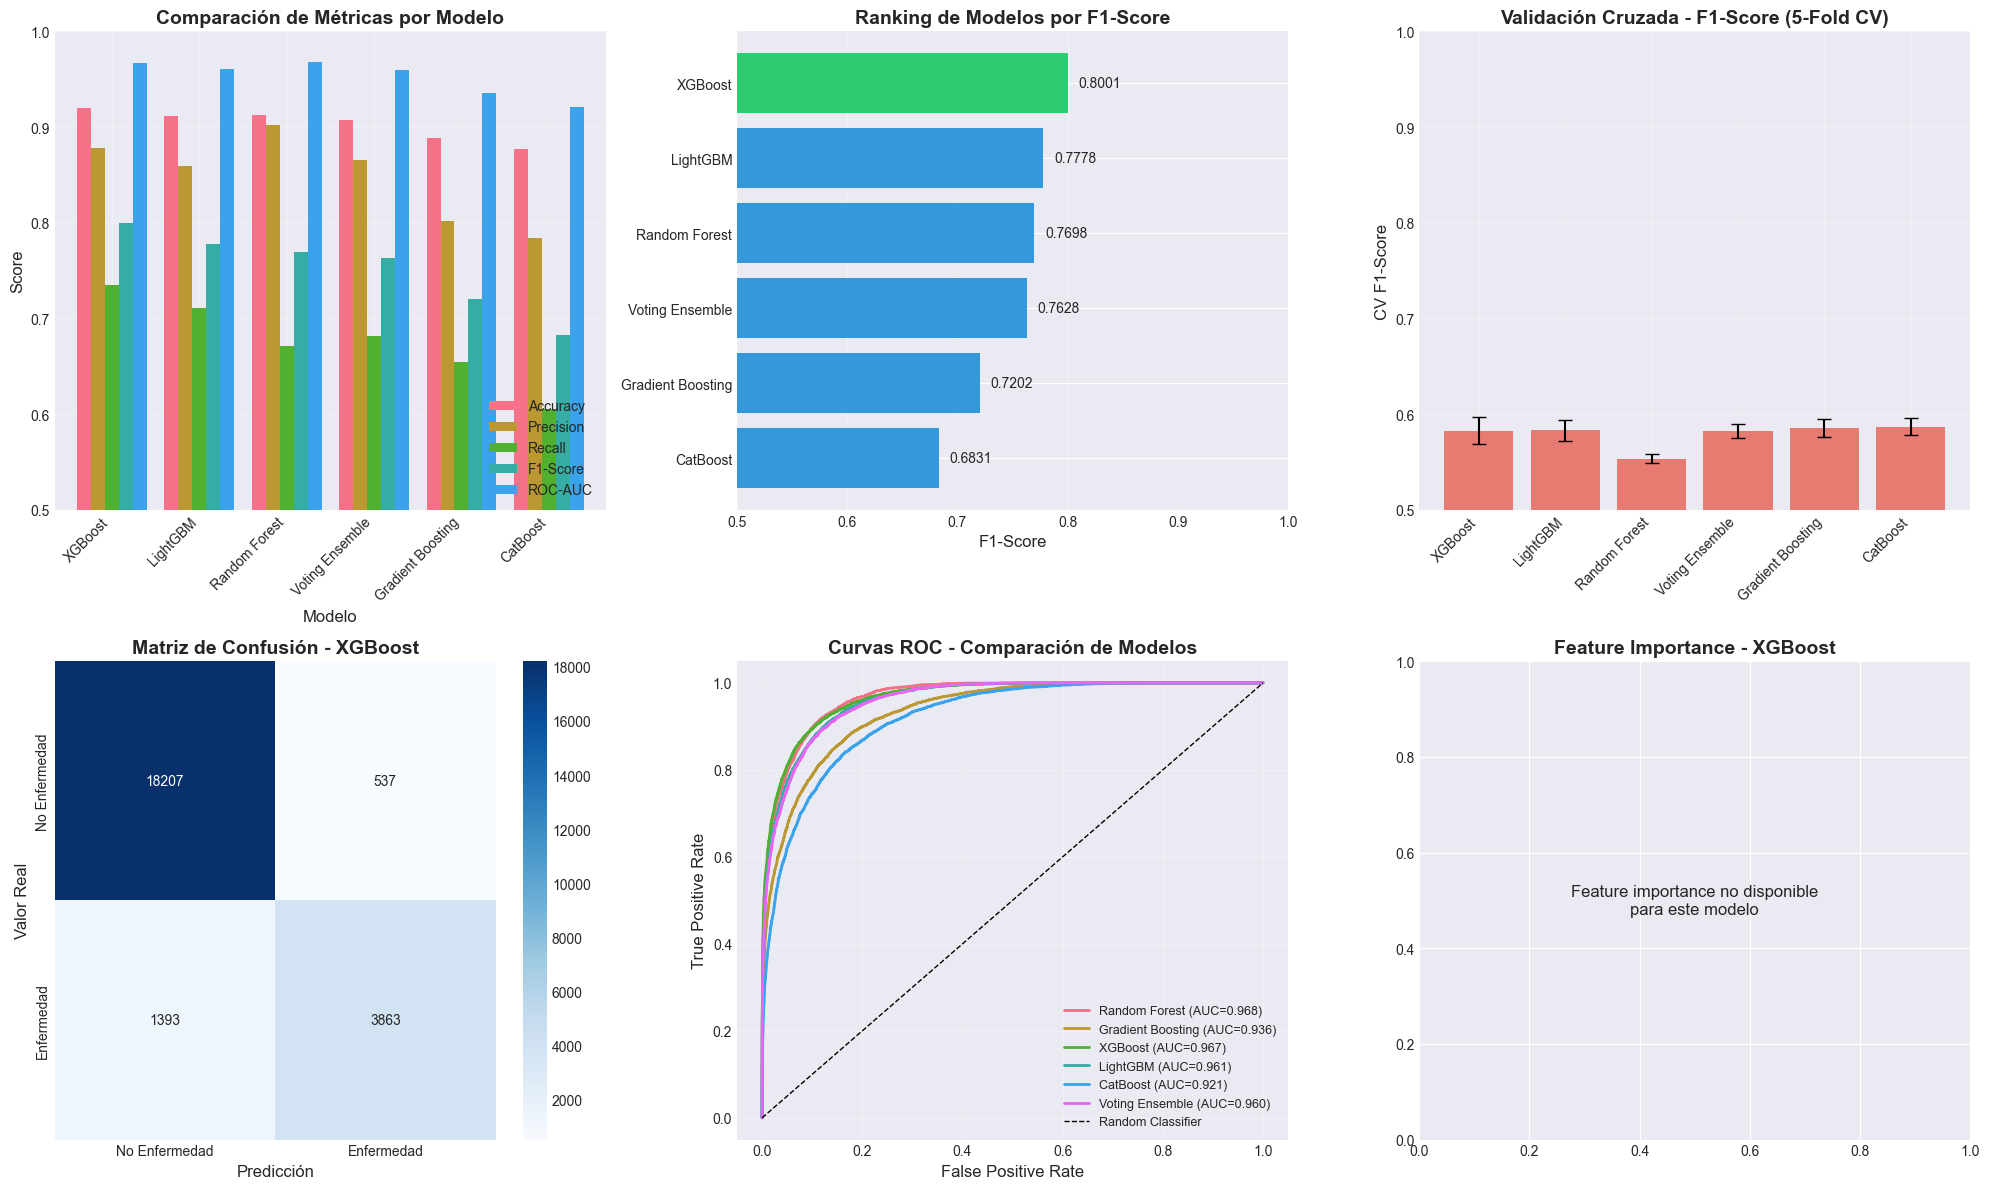


✅ Dashboard de comparación guardado como 'model_comparison_dashboard.png'

RESUMEN FINAL Y RECOMENDACIONES

🥇 Mejor Modelo: XGBoost
   - F1-Score (Train): 0.8001
   - F1-Score (CV): 0.5826 ± 0.0140
   - ROC-AUC: 0.9669

🥈 Segundo Mejor: LightGBM
   - F1-Score (Train): 0.7778
   - F1-Score (CV): 0.5832 ± 0.0109

🥉 Tercer Mejor: Random Forest
   - F1-Score (Train): 0.7698
   - F1-Score (CV): 0.5535 ± 0.0046

💡 RECOMENDACIONES

1. El modelo XGBoost ha mostrado el mejor rendimiento con F1-Score de 0.8001
2. La validación cruzada confirma su robustez con CV F1-Score de 0.5826
3. Se recomienda usar este modelo para generar las predicciones finales
4. Considera optimizar hiperparámetros con GridSearchCV para mejorar aún más
5. El Voting Ensemble suele dar buenos resultados combinando modelos diversos


✅ Resultados guardados en 'model_comparison_results.csv'



In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("EVALUACIÓN Y COMPARACIÓN DE MODELOS")
print("="*80 + "\n")

# Diccionario con todos los modelos
models = {
    'Random Forest': pipeline_rf,
    'Gradient Boosting': pipeline_gb,
    'XGBoost': pipeline_xgb,
    'LightGBM': pipeline_lgbm,
    'CatBoost': pipeline_catboost,
    'Voting Ensemble': pipeline_voting
}

# Almacenar resultados
results = []

# Evaluar cada modelo
for name, model in models.items():
    print(f"Evaluando {name}...")
    
    # Predicciones en train
    y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    
    # Calcular métricas
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_pred_proba)
    
    # Validación cruzada (F1-Score)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    cv_f1_mean = cv_scores.mean()
    cv_f1_std = cv_scores.std()
    
    results.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV F1-Score': cv_f1_mean,
        'CV F1-Std': cv_f1_std
    })

# Crear DataFrame con resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("TABLA DE RESULTADOS - MÉTRICAS EN TRAIN")
print("="*80 + "\n")
print(results_df.to_string(index=False))
print("\n")

# Identificar mejor modelo
best_model_name = results_df.iloc[0]['Modelo']
best_model = models[best_model_name]
best_f1 = results_df.iloc[0]['F1-Score']

print("="*80)
print(f"🏆 MEJOR MODELO: {best_model_name} (F1-Score: {best_f1:.4f})")
print("="*80 + "\n")

# ==================== VISUALIZACIONES ====================

fig = plt.figure(figsize=(20, 12))

# 1. COMPARACIÓN DE MÉTRICAS POR MODELO
ax1 = plt.subplot(2, 3, 1)
metrics_plot = results_df.set_index('Modelo')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
metrics_plot.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Comparación de Métricas por Modelo', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xlabel('Modelo', fontsize=12)
ax1.legend(loc='lower right', fontsize=10)
ax1.set_ylim([0.5, 1.0])
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. F1-SCORE RANKING
ax2 = plt.subplot(2, 3, 2)
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(results_df))]
bars = ax2.barh(results_df['Modelo'], results_df['F1-Score'], color=colors)
ax2.set_xlabel('F1-Score', fontsize=12)
ax2.set_title('Ranking de Modelos por F1-Score', fontsize=14, fontweight='bold')
ax2.set_xlim([0.5, 1.0])
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# 3. VALIDACIÓN CRUZADA (CV F1-SCORE CON BARRAS DE ERROR)
ax3 = plt.subplot(2, 3, 3)
ax3.bar(results_df['Modelo'], results_df['CV F1-Score'], 
        yerr=results_df['CV F1-Std'], capsize=5, color='#e74c3c', alpha=0.7)
ax3.set_title('Validación Cruzada - F1-Score (5-Fold CV)', fontsize=14, fontweight='bold')
ax3.set_ylabel('CV F1-Score', fontsize=12)
ax3.set_ylim([0.5, 1.0])
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. MATRIZ DE CONFUSIÓN DEL MEJOR MODELO
ax4 = plt.subplot(2, 3, 4)
y_pred_best = best_model.predict(X_train)
cm = confusion_matrix(y_train, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, cbar=True,
            xticklabels=['No Enfermedad', 'Enfermedad'],
            yticklabels=['No Enfermedad', 'Enfermedad'])
ax4.set_title(f'Matriz de Confusión - {best_model_name}', fontsize=14, fontweight='bold')
ax4.set_ylabel('Valor Real', fontsize=12)
ax4.set_xlabel('Predicción', fontsize=12)

# 5. CURVAS ROC COMPARATIVAS
ax5 = plt.subplot(2, 3, 5)
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
    auc = roc_auc_score(y_train, y_pred_proba)
    ax5.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

ax5.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax5.set_xlabel('False Positive Rate', fontsize=12)
ax5.set_ylabel('True Positive Rate', fontsize=12)
ax5.set_title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
ax5.legend(loc='lower right', fontsize=9)
ax5.grid(True, alpha=0.3)

# 6. FEATURE IMPORTANCE DEL MEJOR MODELO
ax6 = plt.subplot(2, 3, 6)
try:
    # Obtener el modelo del pipeline
    best_model_estimator = best_model.named_steps[list(best_model.named_steps.keys())[-1]]
    
    # Obtener importancias
    if hasattr(best_model_estimator, 'feature_importances_'):
        importances = best_model_estimator.feature_importances_
    elif hasattr(best_model_estimator, 'estimators_'):  # Para VotingClassifier
        # Promediar importancias de los modelos del ensemble
        importances_list = []
        for est_name, estimator in best_model_estimator.estimators:
            if hasattr(estimator, 'feature_importances_'):
                importances_list.append(estimator.feature_importances_)
        importances = np.mean(importances_list, axis=0)
    
    # Obtener nombres de features después del preprocessing
    feature_names = best_model.named_steps['columntransformer'].get_feature_names_out()
    
    # Crear DataFrame y ordenar
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=True).tail(15)  # Top 15
    
    # Graficar
    ax6.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#9b59b6')
    ax6.set_xlabel('Importancia', fontsize=12)
    ax6.set_title(f'Top 15 Features - {best_model_name}', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='x')
    
except Exception as e:
    ax6.text(0.5, 0.5, f'Feature importance no disponible\npara este modelo', 
             ha='center', va='center', fontsize=12)
    ax6.set_title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Dashboard de comparación guardado como 'model_comparison_dashboard.png'")

# ==================== RESUMEN FINAL ====================

print("\n" + "="*80)
print("RESUMEN FINAL Y RECOMENDACIONES")
print("="*80 + "\n")

print(f"🥇 Mejor Modelo: {best_model_name}")
print(f"   - F1-Score (Train): {results_df.iloc[0]['F1-Score']:.4f}")
print(f"   - F1-Score (CV): {results_df.iloc[0]['CV F1-Score']:.4f} ± {results_df.iloc[0]['CV F1-Std']:.4f}")
print(f"   - ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f}")

print(f"\n🥈 Segundo Mejor: {results_df.iloc[1]['Modelo']}")
print(f"   - F1-Score (Train): {results_df.iloc[1]['F1-Score']:.4f}")
print(f"   - F1-Score (CV): {results_df.iloc[1]['CV F1-Score']:.4f} ± {results_df.iloc[1]['CV F1-Std']:.4f}")

print(f"\n🥉 Tercer Mejor: {results_df.iloc[2]['Modelo']}")
print(f"   - F1-Score (Train): {results_df.iloc[2]['F1-Score']:.4f}")
print(f"   - F1-Score (CV): {results_df.iloc[2]['CV F1-Score']:.4f} ± {results_df.iloc[2]['CV F1-Std']:.4f}")

print("\n" + "="*80)
print("💡 RECOMENDACIONES")
print("="*80)
print(f"""
1. El modelo {best_model_name} ha mostrado el mejor rendimiento con F1-Score de {best_f1:.4f}
2. La validación cruzada confirma su robustez con CV F1-Score de {results_df.iloc[0]['CV F1-Score']:.4f}
3. Se recomienda usar este modelo para generar las predicciones finales
4. Considera optimizar hiperparámetros con GridSearchCV para mejorar aún más
5. El Voting Ensemble suele dar buenos resultados combinando modelos diversos
""")

print("="*80 + "\n")

# Guardar resultados en CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("✅ Resultados guardados en 'model_comparison_results.csv'\n")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import make_pipeline

print("="*80)
print("🎯 ESTRATEGIA ANTI-OVERFITTING Y OPTIMIZACIÓN")
print("="*80 + "\n")

# Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
f1_scorer = make_scorer(f1_score)

# ==================== ESTRATEGIA 1: HIPERPARÁMETROS CONSERVADORES ====================
print("📊 ESTRATEGIA 1: Modelos con Regularización Fuerte")
print("-"*80 + "\n")

# XGBoost con regularización
model_xgb_reg = XGBClassifier(
    n_estimators=100,           # Menos árboles
    max_depth=3,                # Árboles más superficiales
    learning_rate=0.05,         # Aprendizaje más lento
    subsample=0.8,              # Submuestreo
    colsample_bytree=0.8,       # Submuestreo de features
    min_child_weight=5,         # Más restrictivo
    gamma=1,                    # Regularización
    reg_alpha=0.1,              # L1
    reg_lambda=1,               # L2
    random_state=random_state,
    eval_metric='logloss',
    use_label_encoder=False
)

pipeline_xgb_reg = make_pipeline(preprocessor_final, model_xgb_reg)
pipeline_xgb_reg.fit(X_train, y_train)

# Evaluar con CV
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline_xgb_reg, X_train, y_train, cv=cv, scoring=f1_scorer)
print(f"XGBoost Regularizado - CV F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# LightGBM con regularización
model_lgbm_reg = LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    num_leaves=15,              # Menos hojas
    min_child_samples=20,       # Más muestras por hoja
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=random_state,
    verbose=-1
)

pipeline_lgbm_reg = make_pipeline(preprocessor_final, model_lgbm_reg)
cv_scores = cross_val_score(pipeline_lgbm_reg, X_train, y_train, cv=cv, scoring=f1_scorer)
print(f"LightGBM Regularizado - CV F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# CatBoost con regularización
model_catboost_reg = CatBoostClassifier(
    iterations=100,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=3,              # Regularización L2
    random_state=random_state,
    verbose=0
)

pipeline_catboost_reg = make_pipeline(preprocessor_final, model_catboost_reg)
cv_scores = cross_val_score(pipeline_catboost_reg, X_train, y_train, cv=cv, scoring=f1_scorer)
print(f"CatBoost Regularizado - CV F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}\n")

# ==================== ESTRATEGIA 2: GRID SEARCH OPTIMIZACIÓN ====================
print("\n📊 ESTRATEGIA 2: Optimización con GridSearchCV")
print("-"*80 + "\n")

# Grid Search para XGBoost
param_grid_xgb = {
    'xgbclassifier__n_estimators': [50, 100, 150],
    'xgbclassifier__max_depth': [2, 3, 4],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
    'xgbclassifier__min_child_weight': [3, 5, 7],
    'xgbclassifier__subsample': [0.7, 0.8, 0.9],
}

grid_search_xgb = GridSearchCV(
    pipeline_xgb_reg,
    param_grid_xgb,
    cv=cv,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)

print("Optimizando XGBoost... (esto puede tardar varios minutos)")
grid_search_xgb.fit(X_train, y_train)

print(f"\n✅ Mejores parámetros XGBoost: {grid_search_xgb.best_params_}")
print(f"✅ Mejor CV F1-Score: {grid_search_xgb.best_score_:.4f}\n")

best_xgb_pipeline = grid_search_xgb.best_estimator_

# ==================== ESTRATEGIA 3: STACKING ENSEMBLE ====================
print("\n📊 ESTRATEGIA 3: Stacking de Modelos Diversos")
print("-"*80 + "\n")

# Definir modelos base (todos regularizados)
estimators = [
    ('xgb', model_xgb_reg),
    ('lgbm', model_lgbm_reg),
    ('catboost', model_catboost_reg)
]

# Meta-modelo: Regresión Logística con regularización
meta_model = LogisticRegression(C=0.1, random_state=random_state, max_iter=1000)

# Crear Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=cv,
    n_jobs=-1
)

pipeline_stacking = make_pipeline(preprocessor_final, stacking_clf)
pipeline_stacking.fit(X_train, y_train)

# Evaluar Stacking
cv_scores = cross_val_score(pipeline_stacking, X_train, y_train, cv=cv, scoring=f1_scorer)
print(f"Stacking Ensemble - CV F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}\n")

# ==================== ESTRATEGIA 4: THRESHOLD OPTIMIZATION ====================
print("\n📊 ESTRATEGIA 4: Optimización del Umbral de Clasificación")
print("-"*80 + "\n")

from sklearn.metrics import f1_score

# Usar el mejor modelo hasta ahora
best_model = grid_search_xgb.best_estimator_

# Obtener probabilidades
y_proba = best_model.predict_proba(X_train)[:, 1]

# Probar diferentes umbrales
thresholds = np.arange(0.3, 0.7, 0.05)
best_threshold = 0.5
best_f1_threshold = 0

for threshold in thresholds:
    y_pred_threshold = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_train, y_pred_threshold)
    print(f"Umbral: {threshold:.2f} - F1-Score: {f1:.4f}")
    if f1 > best_f1_threshold:
        best_f1_threshold = f1
        best_threshold = threshold

print(f"\n✅ Mejor umbral: {best_threshold:.2f} con F1-Score: {best_f1_threshold:.4f}\n")

# ==================== GENERAR PREDICCIONES CON MEJOR ESTRATEGIA ====================
print("\n" + "="*80)
print("🎯 GENERANDO PREDICCIONES FINALES CON MEJORES ESTRATEGIAS")
print("="*80 + "\n")

# Cargar test
test = pd.read_csv("cardio_risk_test.csv")

# Estrategia 1: XGBoost Optimizado con GridSearch
y_test_pred_optimized = grid_search_xgb.best_estimator_.predict(test)
submission_optimized = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_optimized
})
submission_optimized.to_csv("submission_xgb_optimized.csv", index=False)
print("✅ submission_xgb_optimized.csv generado")

# Estrategia 2: Stacking Ensemble
y_test_pred_stacking = pipeline_stacking.predict(test)
submission_stacking = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_stacking
})
submission_stacking.to_csv("submission_stacking.csv", index=False)
print("✅ submission_stacking.csv generado")

# Estrategia 3: XGBoost con Threshold Optimizado
y_test_proba = grid_search_xgb.best_estimator_.predict_proba(test)[:, 1]
y_test_pred_threshold = (y_test_proba >= best_threshold).astype(int)
submission_threshold = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_threshold
})
submission_threshold.to_csv("submission_xgb_threshold.csv", index=False)
print("✅ submission_xgb_threshold.csv generado con umbral optimizado")

# Estrategia 4: Promedio de Predicciones (Soft Voting Manual)
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict_proba(test)[:, 1]
y_test_pred_stack = pipeline_stacking.predict_proba(test)[:, 1]
y_test_pred_lgbm = pipeline_lgbm_reg.predict_proba(test)[:, 1]

# Promedio ponderado (dar más peso al mejor modelo)
y_test_pred_avg = (0.5 * y_test_pred_xgb + 0.3 * y_test_pred_stack + 0.2 * y_test_pred_lgbm)
y_test_pred_avg_binary = (y_test_pred_avg >= 0.5).astype(int)

submission_avg = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_avg_binary
})
submission_avg.to_csv("submission_weighted_average.csv", index=False)
print("✅ submission_weighted_average.csv generado (promedio ponderado)")

print("\n" + "="*80)
print("📋 RECOMENDACIONES FINALES")
print("="*80)
print("""
1. Sube primero: submission_xgb_optimized.csv (XGBoost con GridSearch)
2. Si no mejora, prueba: submission_stacking.csv (Stacking Ensemble)
3. Luego prueba: submission_xgb_threshold.csv (con umbral optimizado)
4. Finalmente: submission_weighted_average.csv (promedio ponderado)

💡 TIPS ADICIONALES:
- Revisa si hay data leakage en el preprocesamiento
- Verifica que no estés usando información del futuro
- Considera crear nuevas features (feature engineering)
- Prueba modelos más simples (menos features)
- Analiza los errores: ¿qué casos predice mal?
""")
print("="*80)

## 4. Competición en Kaggle

La evaluación final se realizará mediante una competición privada en Kaggle. El objetivo es maximizar la métrica **F1-Score**, una medida robusta que tiene en cuenta tanto la precisión como la exhaustividad, especialmente útil en casos con clases desbalanceadas (como este).

* **Enlace a la competición**: [https://www.kaggle.com/t/4f9d7d0a4cc94a0888c9c928fe4dbbc3](https://www.kaggle.com/t/4f9d7d0a4cc94a0888c9c928fe4dbbc3)

Los equipos con mejor rendimiento en el *private leaderboard* recibirán una bonificación en la nota final:
* **1er puesto**: +0.75 puntos.
* **2º puesto**: +0.5 puntos.
* **3er puesto**: +0.25 puntos.

**Nota**: Las bonificaciones están sujetas a la revisión del código y la metodología. Se podrá requerir una justificación del enfoque para verificar la originalidad y la comprensión del trabajo.

<div style="border-bottom: 2px solid #555555; padding-bottom: 15px; margin-bottom: 10px"></div>

## 5. Desarrollo y Entregables

El entregable principal será un **notebook (o varios)** que recoja todo el proceso, además de los posibles ficheros auxiliares.

Se puede desarrollar la práctica directamente a continuación de esta celda, o si se prefiere, en una libreta nueva. Tened en cuenta que el proceso de minería de datos es **iterativo**. No es realista realizar un EDA, luego un preprocesamiento y luego un modelado de forma aislada; lo habitual es volver atrás, redefinir características, explorarlas y probar nuevos preprocesamientos basándose en los resultados de los modelos.

Para organizar el trabajo, se hacen las siguientes **recomendaciones**:

1.  **Separar Exploración de Producción**: En el EDA se exploran, prueban y analizar los datos libremente. Dada su extensión, se recomienda hacer una libreta solo para el EDA.
2.  **Crear una Libreta "Limpia"**: Una vez se tengan claras las transformaciones a realizar (basadas en el EDA), se puede crear una segunda libreta donde se defina el `Pipeline` de preprocesamiento de forma estructurada y se realicen el entrenamiento y la validación.
3.  **Usar Ficheros Auxiliares**: Para mantener la libreta final ordenada, se pueden definir funciones de transformación complejas en un fichero externo (ej. `utils.py`) y luego importarlas en la libreta. Esto hace el `Pipeline` mucho más legible.1